In [1]:
# 01_relation_similarity_analysis
#
# created by LuYF-Lemon-love <luyanfeng_nlp@qq.com> on March 12, 2023
# updated by LuYF-Lemon-love <luyanfeng_nlp@qq.com> on March 12, 2023
#
# 该脚本展示了如何分析训练的关系嵌入.
#
# 需要的包:
#          numpy
#          csv
#          matplotlib
#          sklearn
#
# 需要的文件:
#          ../01-model/ckpts/TransE_l1_All_DRKG_0/All_DRKG_TransE_l1_relation.npy
#          ../01-model/ckpts/TransE_l2_All_DRKG_0/All_DRKG_TransE_l2_relation.npy
#          ../01-model/ckpts/ComplEx_All_DRKG_0/All_DRKG_ComplEx_relation.npy
#          ../01-model/ckpts/RotatE_All_DRKG_0/All_DRKG_RotatE_relation.npy
#          ../../data/drkg/relations.tsv
#
# 源教程链接: https://github.com/gnn4dr/DRKG/blob/master/embedding_analysis/Relation_similarity_analysis.ipynb

# DRKG Relation Embedding Similarity Analysis
 
这个 notebook 展示了如何分析训练的关系嵌入.

在这个例子中, 我们首先加载训练的嵌入向量, 然后将它们映射回原始的关系名, 最后应用两种方法分析它们:

- 投射嵌入进入低维空间并可视化它们的分布.
- 使用余弦距离分析关系间的相似程度.

In [2]:
import numpy as np
import csv
import sklearn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [3]:
!mkdir -p ./result

## Loading Relation ID Mapping

In [4]:
rel2id = {}
id2rel = {}

with open("../../data/drkg/relations.tsv", newline = '', encoding = 'utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter='\t', fieldnames=['id','rel'])
    for row_val in reader:
        id = row_val['id']
        relation = row_val['rel']

        rel2id[relation] = int(id)
        id2rel[int(id)] = relation

print("Number of relations: {}".format(len(rel2id)))

Number of relations: 107


## Treatment relation

In [5]:
treatment_list = [
'DRUGBANK::treats::Compound:Disease',
'GNBR::T::Compound:Disease',
'Hetionet::CtD::Compound:Disease'
]

In [6]:
treatment_list

['DRUGBANK::treats::Compound:Disease',
 'GNBR::T::Compound:Disease',
 'Hetionet::CtD::Compound:Disease']

## Loading Relation Embeddings

In [7]:
TransE_l1_rel_emb = np.load('../01-model/ckpts/TransE_l1_All_DRKG_0/All_DRKG_TransE_l1_relation.npy')
TransE_l2_rel_emb = np.load('../01-model/ckpts/TransE_l2_All_DRKG_0/All_DRKG_TransE_l2_relation.npy')
ComplEx_rel_emb = np.load('../01-model/ckpts/ComplEx_All_DRKG_0/All_DRKG_ComplEx_relation.npy')
RotatE_rel_emb = np.load('../01-model/ckpts/RotatE_All_DRKG_0/All_DRKG_RotatE_relation.npy')
print(TransE_l1_rel_emb.shape, TransE_l2_rel_emb.shape, ComplEx_rel_emb.shape, RotatE_rel_emb.shape)

(107, 400) (107, 400) (107, 400) (107, 200)


## General Relation Embedding Clustering

这里我们使用 t-SNE 将关系嵌入降维, 然后可视化它们的分布.

In [8]:
# 将关系按照源数据集分类
dataset_id = {}
for rel_name, i in rel2id.items():
    rel_key = rel_name.split('::')[0]
    if dataset_id.get(rel_key, None) is None:
        dataset_id[rel_key] = []
    dataset_id[rel_key].append(i)

In [9]:
# 降维并转置, 降维的结果每次都不同
try:
    X_TransE_l1_embedded = np.load('./result/relation/X_TransE_l1_embedded.npy')
    X_TransE_l2_embedded = np.load('./result/relation/X_TransE_l2_embedded.npy')
    X_ComplEx_embedded = np.load('./result/relation/X_ComplEx_embedded.npy')
    X_RotatE_embedded = np.load('./result/relation/X_RotatE_embedded.npy')
    print("加载之前保存好的 embedded.")
except Exception as e :
    print("重新计算 embedded.")
    X_TransE_l1_embedded = TSNE(n_components=2).fit_transform(TransE_l1_rel_emb).T
    X_TransE_l2_embedded = TSNE(n_components=2).fit_transform(TransE_l2_rel_emb).T
    X_ComplEx_embedded = TSNE(n_components=2).fit_transform(ComplEx_rel_emb).T
    X_RotatE_embedded = TSNE(n_components=2).fit_transform(RotatE_rel_emb).T
    np.save('./result/relation/X_TransE_l1_embedded.npy', X_TransE_l1_embedded)
    np.save('./result/relation/X_TransE_l2_embedded.npy', X_TransE_l2_embedded)
    np.save('./result/relation/X_ComplEx_embedded.npy', X_ComplEx_embedded)
    np.save('./result/relation/X_RotatE_embedded.npy', X_RotatE_embedded)

加载之前保存好的 embedded.


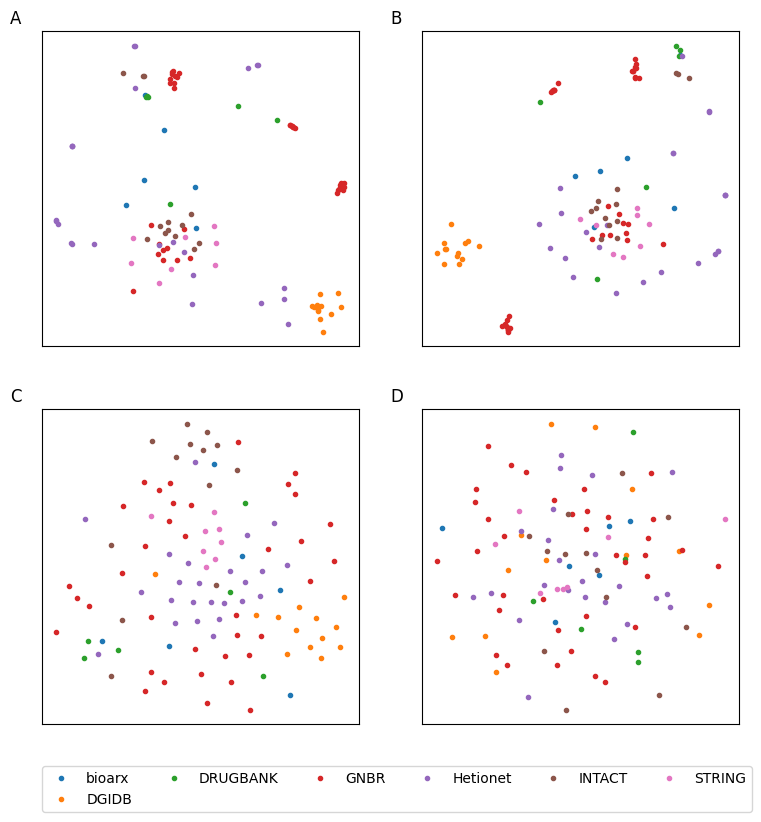

In [27]:
# 绘制，不画 treatments
plt.figure(figsize = (9, 9))

# TransE_l1
plt.subplot(221)
plt.title('A', loc = 'left', position = (-0.1, -0.1))
for key, val in dataset_id.items():
    val = np.asarray(val, dtype=int)
    plt.plot(X_TransE_l1_embedded[0][val], X_TransE_l1_embedded[1][val], '.', label=key)

plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
    
# TransE_l2
plt.subplot(222)
plt.title('B', loc = 'left', position = (-0.1, -0.1))
for key, val in dataset_id.items():
    val = np.asarray(val, dtype=int)
    plt.plot(X_TransE_l2_embedded[0][val], X_TransE_l2_embedded[1][val], '.', label=key)

plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

# ComplEx
plt.subplot(223)
plt.title('C', loc = 'left', position = (-0.1, -0.1))
for key, val in dataset_id.items():
    val = np.asarray(val, dtype=int)
    plt.plot(X_ComplEx_embedded[0][val], X_ComplEx_embedded[1][val], '.', label=key)

plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

# RotatE
plt.subplot(224)
plt.title('D', loc = 'left', position = (-0.1, -0.1))
for key, val in dataset_id.items():
    val = np.asarray(val, dtype=int)
    plt.plot(X_RotatE_embedded[0][val], X_RotatE_embedded[1][val], '.', label=key)

plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
lgd = plt.legend(loc = 'lower center', ncols = 6, bbox_to_anchor=(-0.08, -0.3))
plt.savefig('./result/relation/relation_no_treats.svg', bbox_extra_artists=(lgd,), bbox_inches='tight', format='svg')

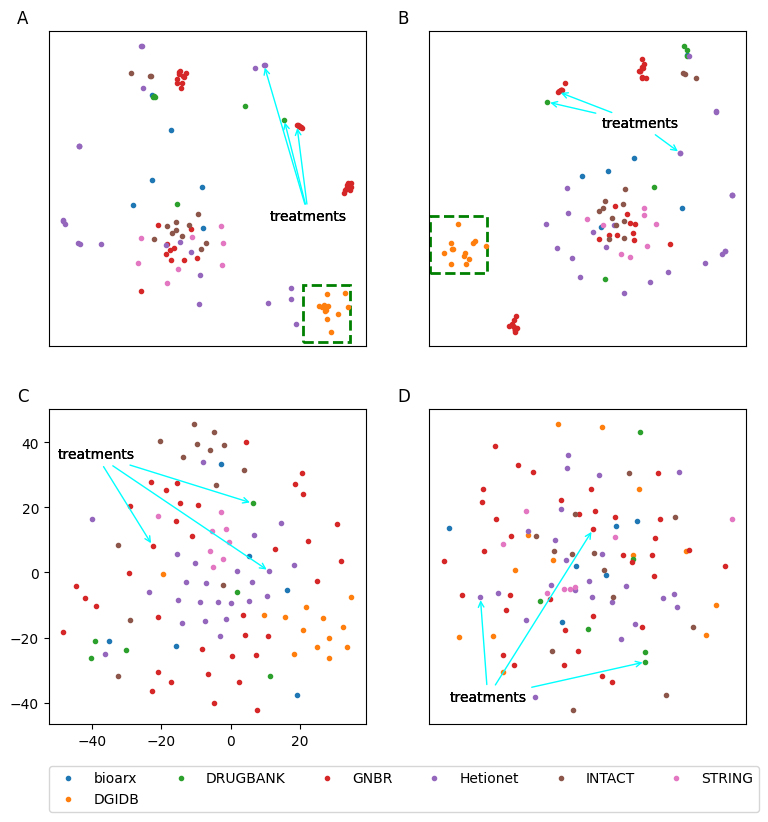

In [107]:
# 绘制
plt.figure(figsize = (9, 9))

# TransE_l1
ax_a = plt.subplot(221)
plt.title('A', loc = 'left', position = (-0.1, -0.1))
for key, val in dataset_id.items():
    val = np.asarray(val, dtype=int)
    plt.plot(X_TransE_l1_embedded[0][val], X_TransE_l1_embedded[1][val], '.', label=key)

for i in range(len(treatment_list)):
    plt.annotate('treatments',
                 xy=(X_TransE_l1_embedded[0][rel2id[treatment_list[i]]], X_TransE_l1_embedded[1][rel2id[treatment_list[i]]]),
                 xytext=(5.0, -1.0),
                 arrowprops=dict(arrowstyle = '->', color = 'cyan', linewidth = 1.0),
                )

ax_a.add_patch(plt.Rectangle((0.6, 0.01), 0.15, 0.18, ls="--", ec="green", fc = "none", linewidth = "2.0", transform=ax.transAxes))

plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
    
# TransE_l2
ax_b = plt.subplot(222)
plt.title('B', loc = 'left', position = (-0.1, -0.1))
for key, val in dataset_id.items():
    val = np.asarray(val, dtype=int)
    plt.plot(X_TransE_l2_embedded[0][val], X_TransE_l2_embedded[1][val], '.', label=key)

for i in range(len(treatment_list)):
    plt.annotate('treatments',
                 xy=(X_TransE_l2_embedded[0][rel2id[treatment_list[i]]], X_TransE_l2_embedded[1][rel2id[treatment_list[i]]]),
                 xytext=(0.5, 3.0),
                 arrowprops=dict(arrowstyle = '->', color = 'cyan', linewidth = 1.0),
                )

ax_b.add_patch(plt.Rectangle((1.0, 0.23), 0.18, 0.18, ls="--", ec="green", fc = "none", linewidth = "2.0", transform=ax.transAxes))

plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

# ComplEx
ax_c = plt.subplot(223)
plt.title('C', loc = 'left', position = (-0.1, -0.1))
for key, val in dataset_id.items():
    val = np.asarray(val, dtype=int)
    plt.plot(X_ComplEx_embedded[0][val], X_ComplEx_embedded[1][val], '.', label=key)

for i in range(len(treatment_list)):
    plt.annotate('treatments',
                 xy=(X_ComplEx_embedded[0][rel2id[treatment_list[i]]], X_ComplEx_embedded[1][rel2id[treatment_list[i]]]),
                 xytext=(-50.0, 35.0),
                 arrowprops=dict(arrowstyle = '->', color = 'cyan', linewidth = 1.0),
                )

ax_c.add_patch(plt.Rectangle((-5.0, 35.0), 0.15, 0.5, ls="--", ec="green", fc = "none", linewidth = "2.0", transform=ax.transAxes))

#plt.gca().get_xaxis().set_visible(False)
#plt.gca().get_yaxis().set_visible(False)

# RotatE
ax_d = plt.subplot(224)
plt.title('D', loc = 'left', position = (-0.1, -0.1))
for key, val in dataset_id.items():
    val = np.asarray(val, dtype=int)
    plt.plot(X_RotatE_embedded[0][val], X_RotatE_embedded[1][val], '.', label=key)

for i in range(len(treatment_list)):
    plt.annotate('treatments',
                 xy=(X_RotatE_embedded[0][rel2id[treatment_list[i]]], X_RotatE_embedded[1][rel2id[treatment_list[i]]]),
                 xytext=(-0.2, -1.5),
                 arrowprops=dict(arrowstyle = '->', color = 'cyan', linewidth = 1.0),
                )
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
lgd = plt.legend(loc = 'lower center', ncols = 6, bbox_to_anchor=(-0.08, -0.3))
plt.savefig('./result/relation/relation.svg', bbox_extra_artists=(lgd,), bbox_inches='tight', format='svg')

## Pair-wise Relation Embedding Cosine Similarity

我们使用余弦距离计算成对的嵌入相似度, 然后输出最相似的 10 对.

In [12]:
# 计算余弦相似度
similarity_TransE_l1 = sklearn.metrics.pairwise.cosine_similarity(TransE_l1_rel_emb)
similarity_TransE_l2 = sklearn.metrics.pairwise.cosine_similarity(TransE_l2_rel_emb)
similarity_ComplEx = sklearn.metrics.pairwise.cosine_similarity(ComplEx_rel_emb)
similarity_RotatE = sklearn.metrics.pairwise.cosine_similarity(RotatE_rel_emb)
similaritys = [similarity_TransE_l1, similarity_TransE_l2, similarity_ComplEx, similarity_RotatE]

In [13]:
def sort_score(pair):
    return pair[2]

def output_similarity(similarity, file):
    # 在每一行上, 利用相似度将元素 Index 按降序排列
    idx = np.flip(np.argsort(similarity), axis = 1)
    
    max_pairs = []
    for i in range(idx.shape[0]):
        j = 1
        while (similarity[i][idx[i][j]] > 0):
            max_pairs.append((id2rel[idx[i][0]], id2rel[idx[i][j]], similarity[i][idx[i][j]]))
            j += 1
    
    # 按照 score 降序 
    max_pairs.sort(reverse=True, key = sort_score)
    
    sim_pairs = []
    for i, pair in enumerate(max_pairs):
        # 相似度矩阵是对称的, 因此有两个 score 完全一样的记录
        if i % 2 == 0:
            sim_pairs.append(pair)
    
    results_similarity = ["{}\t{}\t{}\n".format(pair[0], pair[1], pair[2]) for pair in sim_pairs]
    results_similarity = ["relation_1\trelation_2\tpair-wise relation embedding cosine similarity\n"] + results_similarity
    with open(file, 'w+') as f:
        f.writelines(results_similarity)

In [14]:
files = [
    "./result/relation/cosine_similarity_TransE_l1_rel_emb.tsv",
    "./result/relation/cosine_similarity_TransE_l2_rel_emb.tsv",
    "./result/relation/cosine_similarity_ComplEx_rel_emb.tsv",
    "./result/relation/cosine_similarity_RotatE_rel_emb.tsv",
]

for i in range(len(similaritys)):
    output_similarity(similaritys[i], files[i])

然后, 我们绘制了成对相似度得分分布的直方图.

In [15]:
def plot_similarity(similarity):
    # 将相似度矩阵平铺
    similarity = similarity.flatten()
    print(similarity.shape)
    
    # 清除 self-compare 和 dup-compare
    s = similarity < 0.99
    s = np.unique(similarity[s])
    return s

(11449,)
(11449,)
(11449,)
(11449,)


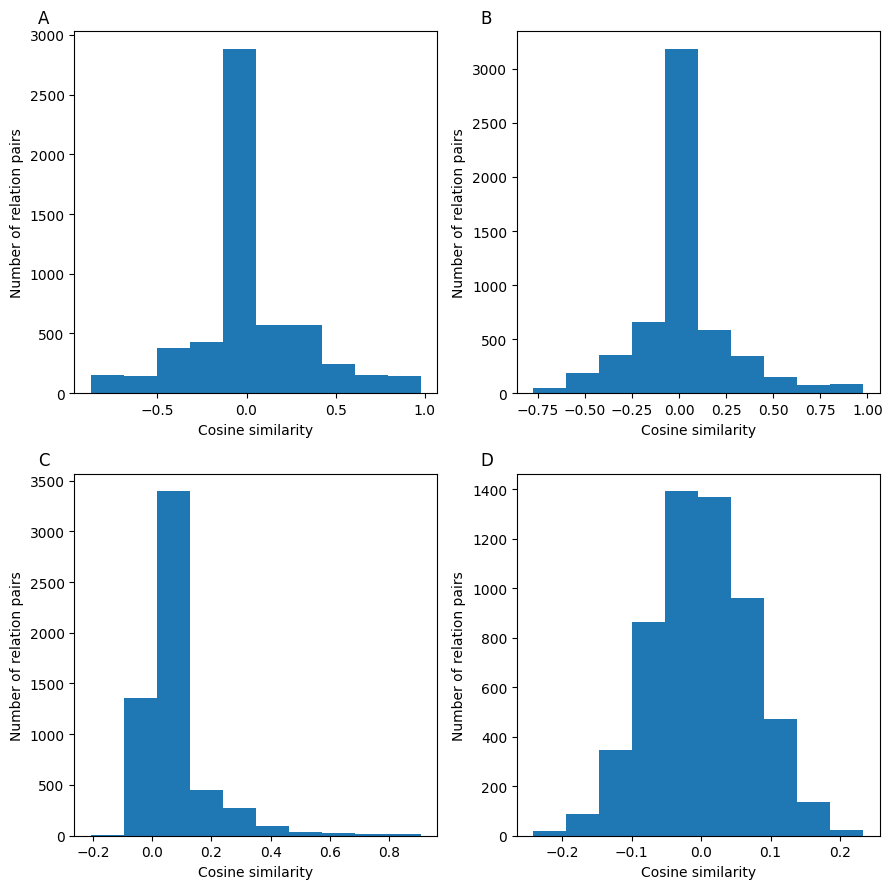

In [16]:
# 绘制，不画 treats
plt.figure(figsize = (9, 9))

# TransE_l1
ax = plt.subplot(221)
plt.title('A', loc = 'left', position = (-0.1, -0.1))

plt.xlabel('Cosine similarity')
plt.ylabel('Number of relation pairs')
plt.hist(plot_similarity(similaritys[0]))
    
# TransE_l2
plt.subplot(222)
plt.title('B', loc = 'left', position = (-0.1, -0.1))

plt.xlabel('Cosine similarity')
plt.ylabel('Number of relation pairs')
plt.hist(plot_similarity(similaritys[1]))

# ComplEx
plt.subplot(223)
plt.title('C', loc = 'left', position = (-0.1, -0.1))

plt.xlabel('Cosine similarity')
plt.ylabel('Number of relation pairs')
plt.hist(plot_similarity(similaritys[2]))

# RotatE
plt.subplot(224)
plt.title('D', loc = 'left', position = (-0.1, -0.1))

plt.xlabel('Cosine similarity')
plt.ylabel('Number of relation pairs')
plt.hist(plot_similarity(similaritys[3]))

plt.tight_layout()
plt.savefig('./result/relation/relation-sim.svg', format='svg')